# 3-1,低阶 API 示范

下面的范例使用 TensorFlow 的低阶 API 实现线性回归模型和 DNN 二分类模型。

低阶 API 主要包括张量操作，计算图和自动微分。

In [46]:
import tensorflow as tf

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# 打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp() % (24 * 60 * 60)

    hour = tf.cast(today_ts // 3600 + 8, tf.int32) % tf.constant(24)
    minute = tf.cast((today_ts % 3600) // 60, tf.int32)
    second = tf.cast(tf.floor(today_ts % 60), tf.int32)

    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}", m)) == 1:
            return tf.strings.format("0{}", m)
        else:
            return tf.strings.format("{}", m)

    timestring = tf.strings.join(
        [timeformat(hour), timeformat(minute), timeformat(second)], separator=":"
    )
    tf.print("==========" * 8 + timestring)


### 一，线性回归模型

#### 1，准备数据

In [47]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf

# 样本数量
n = 400

# 生成测试数据集
X = tf.random.uniform([n, 2], minval=-10, maxval=10)  # 均匀分布
w0 = tf.constant([[2.0], [-3.0]])
b0 = tf.constant([3.0])
Y = X @ w0 + b0 + tf.random.normal([n, 1], mean=0.0, stddev=2.0)  # @ 表示矩阵乘法,增加正态扰动


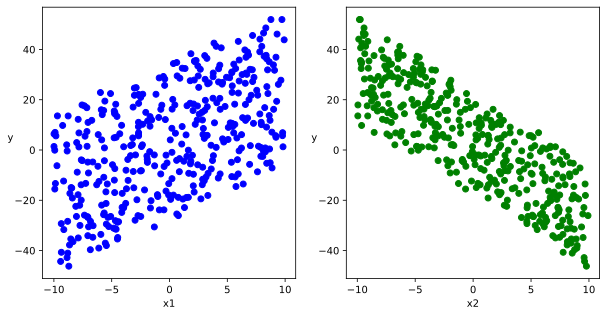

In [48]:
# 数据可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0], Y[:, 0], c="b")
plt.xlabel("x1")
plt.ylabel("y", rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1], Y[:, 0], c="g")
plt.xlabel("x2")
plt.ylabel("y", rotation=0)

plt.show()

In [49]:
# 构建数据管道
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        indexs = indices[i : min(i + batch_size, num_examples)]
        yield tf.gather(features, indexs), tf.gather(labels, indexs)


# 测试数据管道效果
batch_size = 8
(features, labels) = next(data_iter(X, Y, batch_size))
print(features)
print(labels)


tf.Tensor(
[[ 2.8354855   7.9367046 ]
 [ 4.3854284  -0.67572117]
 [ 8.483723   -3.5630774 ]
 [-8.707967    9.7803135 ]
 [-9.353807    7.7737217 ]
 [-0.87882805  7.429577  ]
 [-3.581159    2.7051735 ]
 [-9.140458    5.5320053 ]], shape=(8, 2), dtype=float32)
tf.Tensor(
[[-13.80447  ]
 [ 16.196142 ]
 [ 31.898582 ]
 [-46.227528 ]
 [-40.69766  ]
 [-23.830254 ]
 [-12.0877905]
 [-31.673391 ]], shape=(8, 1), dtype=float32)


#### 2，定义模型

In [50]:
w = tf.Variable(tf.random.normal(w0.shape))
b = tf.Variable(tf.zeros_like(b0, dtype=tf.float32))

# 定义模型
class LinearRegression(object):
    # 正向传播
    def __call__(self, x):
        return x @ w + b

    # 损失函数
    def loss_func(self, y_true, y_pred):
        return tf.reduce_mean((y_true - y_pred) ** 2 / 2)


model = LinearRegression()


#### 3，训练模型

In [51]:
# 使用动态图调试
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)
    # 反向传播求梯度
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
    # 梯度下降法更新参数
    w.assign(w - 0.001 * dloss_dw)
    b.assign(b - 0.001 * dloss_db)

    return loss

In [52]:
# 测试 train_step 效果
batch_size = 10
(features, labels) = next(data_iter(X, Y, batch_size))
train_step(model, features, labels)

<tf.Tensor: shape=(), dtype=float32, numpy=1057.8181>

In [53]:
def train(model, epochs):
    for epoch in tf.range(1, epochs + 1):
        for features, labels in data_iter(X, Y, batch_size):
            loss = train_step(model, features, labels)

        if epoch % 20 == 0:
            printbar()
            tf.print("epoch = ", epoch, " loss = ", loss)
            tf.print("w = ", w)
            tf.print("b = ", b)


train(model, 200)

================================================================================18:38:29
epoch =  20  loss =  3.61986089
w =  [[1.99247682]
 [-3.02336407]]
b =  [1.65986514]
================================================================================18:38:31
epoch =  40  loss =  2.92307019
w =  [[1.96994722]
 [-3.01747608]]
b =  [2.37802553]
================================================================================18:38:33
epoch =  60  loss =  1.18120539
w =  [[1.97144747]
 [-3.01141882]]
b =  [2.70018339]
================================================================================18:38:34
epoch =  80  loss =  2.48635364
w =  [[1.97963953]
 [-3.01553273]]
b =  [2.8433609]
================================================================================18:38:36
epoch =  100  loss =  2.29469967
w =  [[1.97729695]
 [-3.02616072]]
b =  [2.90893173]
================================================================================18:38:38
epoch =  120  loss =  2.06818414
w =  [[1

In [54]:
# 使用 autograph 机制转换成静态图加速
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)
    # 反向传播求梯度
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
    # 梯度下降法更新参数
    w.assign(w - 0.001 * dloss_dw)
    b.assign(b - 0.001 * dloss_db)

    return loss


def train(model, epochs):
    for epoch in tf.range(1, epochs + 1):
        for features, labels in data_iter(X, Y, batch_size):
            loss = train_step(model, features, labels)

        if epoch % 20 == 0:
            printbar()
            tf.print("epoch = ", epoch, " loss = ", loss)
            tf.print("w = ", w)
            tf.print("b = ", b)


train(model, 200)

================================================================================18:38:47
epoch =  20  loss =  2.02571535
w =  [[1.97130454]
 [-3.01654887]]
b =  [2.96134591]
================================================================================18:38:48
epoch =  40  loss =  2.2490232
w =  [[1.97833836]
 [-3.0129149]]
b =  [2.96190023]
================================================================================18:38:49
epoch =  60  loss =  1.30752432
w =  [[1.97788751]
 [-3.00741124]]
b =  [2.96163]
================================================================================18:38:50
epoch =  80  loss =  3.57193518
w =  [[1.9770236]
 [-3.02386212]]
b =  [2.9611156]
================================================================================18:38:51
epoch =  100  loss =  1.08097172
w =  [[1.97580838]
 [-3.02107882]]
b =  [2.9612565]
================================================================================18:38:53
epoch =  120  loss =  3.34688115
w =  [[1.974749

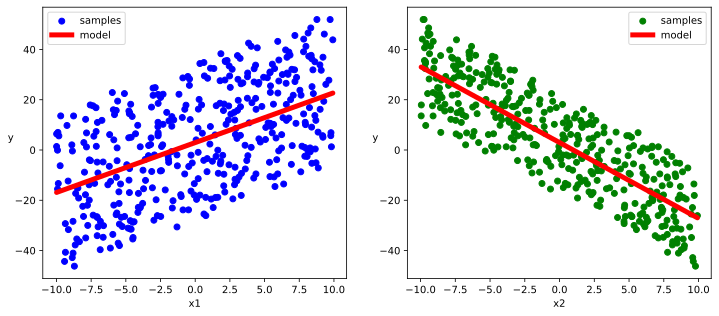

In [55]:
# 结果可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0], Y[:, 0], c="b", label="samples")
ax1.plot(X[:, 0], w[0] * X[:, 0] + b[0], "-r", linewidth=5.0, label="model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y", rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1], Y[:, 0], c="g", label="samples")
ax2.plot(X[:, 1], w[1] * X[:, 1] + b[0], "-r", linewidth=5.0, label="model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y", rotation=0)

plt.show()

### 二，DNN二分类模型

#### 1，准备数据

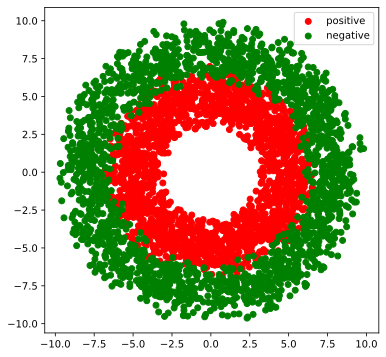

In [56]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, optimizers

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 正负样本数量
n_positive, n_negative = 2000, 2000

# 生成正样本, 小圆环分布
r_p = 5.0 + tf.random.truncated_normal([n_positive, 1], 0.0, 1.0)
theta_p = tf.random.uniform([n_positive, 1], 0.0, 2 * np.pi)
Xp = tf.concat([r_p * tf.cos(theta_p), r_p * tf.sin(theta_p)], axis=1)
Yp = tf.ones_like(r_p)

# 生成负样本, 大圆环分布
r_n = 8.0 + tf.random.truncated_normal([n_negative, 1], 0.0, 1.0)
theta_n = tf.random.uniform([n_negative, 1], 0.0, 2 * np.pi)
Xn = tf.concat([r_n * tf.cos(theta_n), r_n * tf.sin(theta_n)], axis=1)
Yn = tf.zeros_like(r_n)

# 汇总样本
X = tf.concat([Xp, Xn], axis=0)
Y = tf.concat([Yp, Yn], axis=0)

# 样本洗牌
data = tf.concat([X, Y], axis=1)
data = tf.random.shuffle(data)
X = data[:, :2]
Y = data[:, 2:]

# 可视化
plt.figure(figsize=(6, 6))
plt.scatter(Xp[:, 0].numpy(), Xp[:, 1].numpy(), c="r")
plt.scatter(Xn[:, 0].numpy(), Xn[:, 1].numpy(), c="g")
plt.legend(["positive", "negative"])

In [57]:
ds_train = (
    tf.data.Dataset.from_tensor_slices((X[0 : n * 3 // 4, :], Y[0 : n * 3 // 4, :]))
    .shuffle(buffer_size=1000)
    .batch(20)
    .prefetch(tf.data.experimental.AUTOTUNE)
    .cache()
)

ds_valid = (
    tf.data.Dataset.from_tensor_slices((X[n * 3 // 4 :, :], Y[n * 3 // 4 :, :]))
    .batch(20)
    .prefetch(tf.data.experimental.AUTOTUNE)
    .cache()
)

#### 2，定义模型

In [58]:
tf.keras.backend.clear_session()


class DNNModel(tf.keras.models.Model):
    def __init__(self):
        super(DNNModel, self).__init__()

    def build(self, input_shape):
        self.dense1 = layers.Dense(4, activation="relu", name="dense1")
        self.dense2 = layers.Dense(8, activation="relu", name="dense2")
        self.dense3 = layers.Dense(1, activation="sigmoid", name="dense3")
        super(DNNModel, self).build(input_shape)

    # 正向传播
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 2], dtype=tf.float32)])
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        y = self.dense3(x)
        return y


model = DNNModel()
model.build(input_shape=(None, 2))

model.summary()

Model: "dnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              multiple                  12        
                                                                 
 dense2 (Dense)              multiple                  40        
                                                                 
 dense3 (Dense)              multiple                  9         
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


#### 3，训练模型

In [59]:
# 使用 fit 方法进行训练
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.fit(X, Y, batch_size=10, epochs=20)

tf.print("w = ", model.layers[0].kernel)
tf.print("b = ", model.layers[0].bias)

Epoch 1/20
400/400 [==============================] - 1s 2ms/step - loss: 0.2423 - mae: 0.4883
Epoch 2/20
400/400 [==============================] - 1s 2ms/step - loss: 0.2350 - mae: 0.4792
Epoch 3/20
400/400 [==============================] - 1s 2ms/step - loss: 0.2277 - mae: 0.4697
Epoch 4/20
400/400 [==============================] - 1s 2ms/step - loss: 0.2213 - mae: 0.4608
Epoch 5/20
400/400 [==============================] - 1s 2ms/step - loss: 0.2153 - mae: 0.4518
Epoch 6/20
400/400 [==============================] - 1s 2ms/step - loss: 0.2099 - mae: 0.4433
Epoch 7/20
400/400 [==============================] - 1s 2ms/step - loss: 0.2050 - mae: 0.4351
Epoch 8/20
400/400 [==============================] - 1s 2ms/step - loss: 0.2006 - mae: 0.4270
Epoch 9/20
400/400 [==============================] - 1s 2ms/step - loss: 0.1961 - mae: 0.4196
Epoch 10/20
400/400 [==============================] - 1s 2ms/step - loss: 0.1894 - mae: 0.4085
Epoch 11/20
400/400 [============================

In [60]:
### 自定义训练循环
optimizer = optimizers.Adam(learning_rate=0.01)
loss_func = tf.keras.losses.BinaryCrossentropy()

train_loss = tf.keras.metrics.Mean(name="train_loss")
train_metric = tf.keras.metrics.BinaryAccuracy(name="train_accuracy")

valid_loss = tf.keras.metrics.Mean(name="valid_loss")
valid_metric = tf.keras.metrics.BinaryAccuracy(name="valid_accuracy")


@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = loss_func(labels, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss.update_state(loss)
    train_metric.update_state(labels, predictions)


@tf.function
def valid_step(model, features, labels):
    predictions = model(features)
    batch_loss = loss_func(labels, predictions)
    valid_loss.update_state(batch_loss)
    valid_metric.update_state(labels, predictions)


def train_model(model, ds_train, ds_valid, epochs):
    for epoch in tf.range(1, epochs + 1):
        for features, labels in ds_train:
            train_step(model, features, labels)

        for features, labels in ds_valid:
            valid_step(model, features, labels)

        logs = "Epoch:{}, Train Loss:{}, Train Accuracy:{}, Valid Loss:{}, Valid Accuracy:{}"

        if epoch % 100 == 0:
            printbar()
            tf.print(
                tf.strings.format(
                    logs,
                    (
                        epoch,
                        train_loss.result(),
                        train_metric.result(),
                        valid_loss.result(),
                        valid_metric.result(),
                    ),
                )
            )

        train_loss.reset_states()
        valid_loss.reset_states()
        train_metric.reset_states()
        valid_metric.reset_states()


train_model(model, ds_train, ds_valid, 1000)

================================================================================18:39:37
Epoch:100, Train Loss:0.0943851471, Train Accuracy:0.96, Valid Loss:0.173623964, Valid Accuracy:0.937567592
================================================================================18:39:57
Epoch:200, Train Loss:0.0795788541, Train Accuracy:0.963333309, Valid Loss:0.18224448, Valid Accuracy:0.943243265
================================================================================18:40:17
Epoch:300, Train Loss:0.0957486778, Train Accuracy:0.963333309, Valid Loss:0.221176937, Valid Accuracy:0.930810809
================================================================================18:40:37
Epoch:400, Train Loss:0.0758865401, Train Accuracy:0.963333309, Valid Loss:0.198115602, Valid Accuracy:0.937567592
================================================================================18:40:57
Epoch:500, Train Loss:0.0665838569, Train Accuracy:0.976666689, Valid Loss:0.193419456, Valid Accuracy:

Text(0.5, 1.0, 'y_pred')

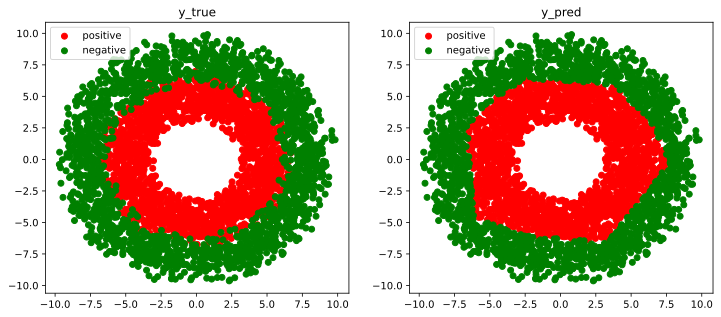

In [61]:
# 结果可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(Xp[:, 0].numpy(), Xp[:, 1].numpy(), c="r")
ax1.scatter(Xn[:, 0].numpy(), Xn[:, 1].numpy(), c="g")
ax1.legend(["positive", "negative"])
ax1.set_title("y_true")

Xp_pred = tf.boolean_mask(X, tf.squeeze(model(X) >= 0.5), axis=0)
Xn_pred = tf.boolean_mask(X, tf.squeeze(model(X) < 0.5), axis=0)

ax2.scatter(Xp_pred[:, 0].numpy(), Xp_pred[:, 1].numpy(), c="r")
ax2.scatter(Xn_pred[:, 0].numpy(), Xn_pred[:, 1].numpy(), c="g")
ax2.legend(["positive", "negative"])
ax2.set_title("y_pred")
